In [1]:
import pandas as pd


In [4]:
merged = pd.read_parquet('merged_eth_usdt_vwap_oct2025.parquet', engine = 'pyarrow')
merged.dropna(inplace = True)
merged

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761954255000,3858.177483,3857.259093
1761954267000,3858.239828,3857.645999
1761954306000,3858.445123,3858.569559


/home/migilin/.venvs/pipenv-env/lib/python3.13/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)
/home/migilin/.venvs/pipenv-env/lib/python3.13/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)


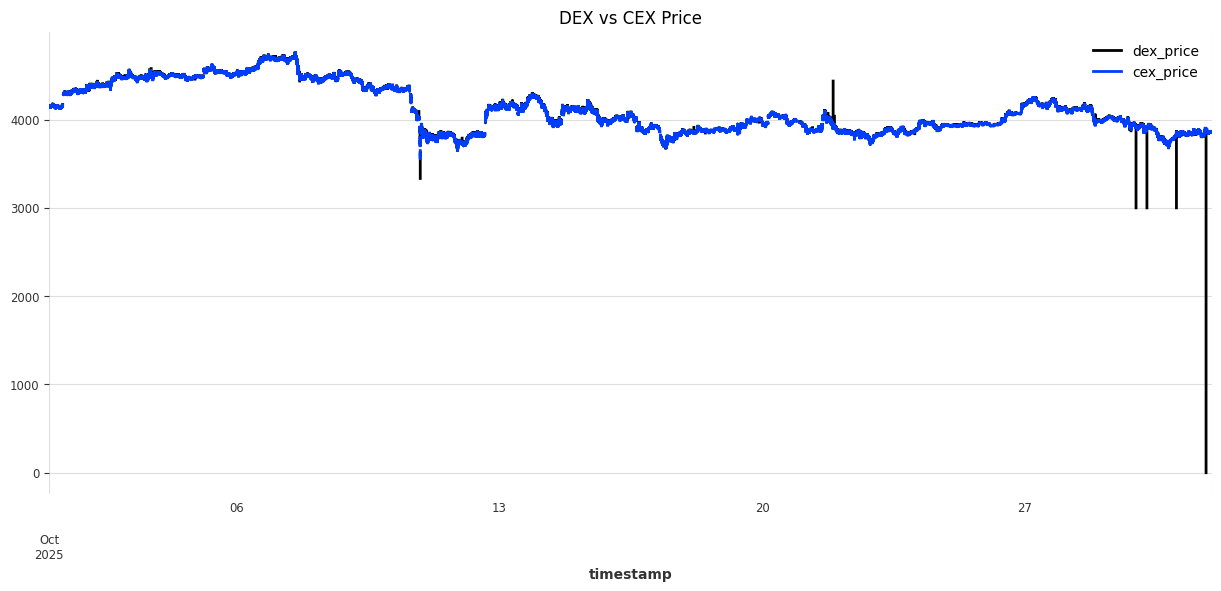

In [7]:
from darts import TimeSeries
import matplotlib.pyplot as plt

# Ensure index is sorted and in datetime format
merged.sort_index(inplace=True)
if not isinstance(merged.index, pd.DatetimeIndex):
    merged.index = pd.to_datetime(merged.index, unit='ms')

# Create TimeSeries objects
# We set fill_missing_dates=True and freq='3S' to handle potential gaps in the data
ts_dex = TimeSeries.from_dataframe(merged, value_cols='dex_price', fill_missing_dates=True, freq='3S')
ts_cex = TimeSeries.from_dataframe(merged, value_cols='cex_price', fill_missing_dates=True, freq='3S')

# Plot the two price series
plt.figure(figsize=(15, 6))
ts_dex.plot(label='dex_price')
ts_cex.plot(label='cex_price')
plt.title('DEX vs CEX Price')
plt.show()

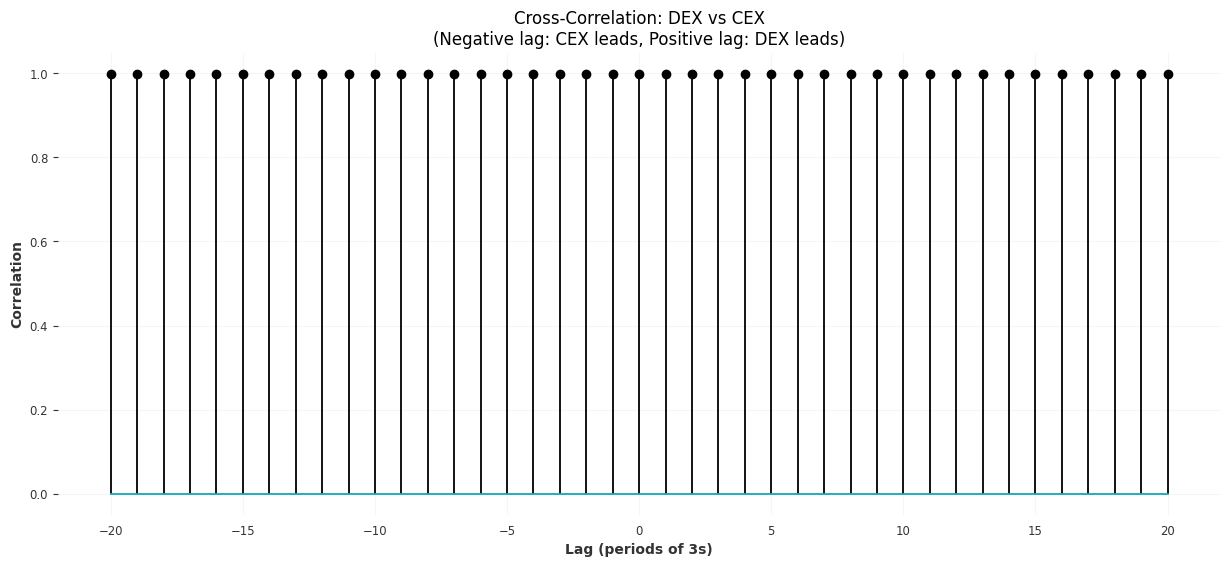

Maximum correlation is at lag 0 (periods of 3s)


In [10]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# Prepare data for analysis
# We use the TimeSeries objects to ensure we have a regular frequency (filled gaps)
# Convert back to pandas for statsmodels
df_dex = ts_dex.to_dataframe()
df_cex = ts_cex.to_dataframe()
df_filled = pd.concat([df_dex, df_cex], axis=1)

# Fill any NaNs introduced by filling missing dates (using forward fill for prices)
df_filled.ffill(inplace=True)
df_filled.dropna(inplace=True)

# 1. Cross-Correlation Analysis
# Calculate correlation for different lags
def cross_correlation(data_x, data_y, lag=0):
    return data_x.corr(data_y.shift(lag))

lags_range = range(-20, 21)
corrs = [cross_correlation(df_filled['dex_price'], df_filled['cex_price'], lag) for lag in lags_range]

plt.figure(figsize=(15, 6))
plt.stem(lags_range, corrs)
plt.title('Cross-Correlation: DEX vs CEX\n(Negative lag: CEX leads, Positive lag: DEX leads)')
plt.xlabel('Lag (periods of 3s)')
plt.ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.show()

# Find the lag with maximum correlation
max_corr_idx = np.argmax(corrs)
best_lag = lags_range[max_corr_idx]
print(f"Maximum correlation is at lag {best_lag} (periods of 3s)")

In [14]:
# 2. Granger Causality
# Granger Causality requires stationary time series.
# Prices are typically non-stationary, so we should use returns (differenced data).

# Calculate percentage returns to make the series stationary
df_returns = df_filled[['dex_price', 'cex_price']].pct_change()

# Replace infinite values with NaN and drop them (in case of division by zero)
df_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
df_returns.dropna(inplace=True)

max_lag = 10

print(f"\nGranger Causality: Does CEX cause DEX? (checking lags 1 to {max_lag})")
# (target, predictor) -> (DEX, CEX)
# We check if CEX returns Granger-cause DEX returns
gc_res_cex_leads = grangercausalitytests(df_returns[['dex_price', 'cex_price']], maxlag=max_lag, verbose=True)

print(f"\n{'='*50}\n")

print(f"Granger Causality: Does DEX cause CEX? (checking lags 1 to {max_lag})")
# (target, predictor) -> (CEX, DEX)
# We check if DEX returns Granger-cause CEX returns
gc_res_dex_leads = grangercausalitytests(df_returns[['cex_price', 'dex_price']], maxlag=max_lag, verbose=True)


Granger Causality: Does CEX cause DEX? (checking lags 1 to 10)

Granger Causality
number of lags (no zero) 1


/home/migilin/.venvs/pipenv-env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=70.1184 , p=0.0000  , df_denom=892507, df_num=1
ssr based chi2 test:   chi2=70.1186 , p=0.0000  , df=1
likelihood ratio test: chi2=70.1158 , p=0.0000  , df=1
parameter F test:         F=70.1184 , p=0.0000  , df_denom=892507, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=143.4882, p=0.0000  , df=2
likelihood ratio test: chi2=143.4767, p=0.0000  , df=2
parameter F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=143.4882, p=0.0000  , df=2
likelihood ratio test: chi2=143.4767, p=0.0000  , df=2
parameter F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=108.3032, p=0.0000  , df_denom=892501, df_num=3


/home/migilin/.venvs/pipenv-env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=9.6952  , p=0.0018  , df_denom=892507, df_num=1
ssr based chi2 test:   chi2=9.6952  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6952  , p=0.0018  , df=1
parameter F test:         F=9.6952  , p=0.0018  , df_denom=892507, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=12.6410 , p=0.0018  , df=2
likelihood ratio test: chi2=12.6409 , p=0.0018  , df=2
parameter F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=12.6410 , p=0.0018  , df=2
likelihood ratio test: chi2=12.6409 , p=0.0018  , df=2
parameter F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4622  , p=0.0039  , df_denom=892501, df_num=3


/home/migilin/.venvs/pipenv-env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Dec, 2025
Time:                     10:59:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.8824
Nobs:                     892496.    HQIC:                  -29.8830
Log likelihood:       1.08026e+07    FPE:                1.05170e-13
AIC:                     -29.8832    Det(Omega_mle):     1.05162e-13
--------------------------------------------------------------------
Results for equation dex_price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000001         0.000001           -0.617           0.537
L1.dex_price         -0.008612         0.001072           -8.036           0.000
L1.cex_price          0.054383         0.006387         

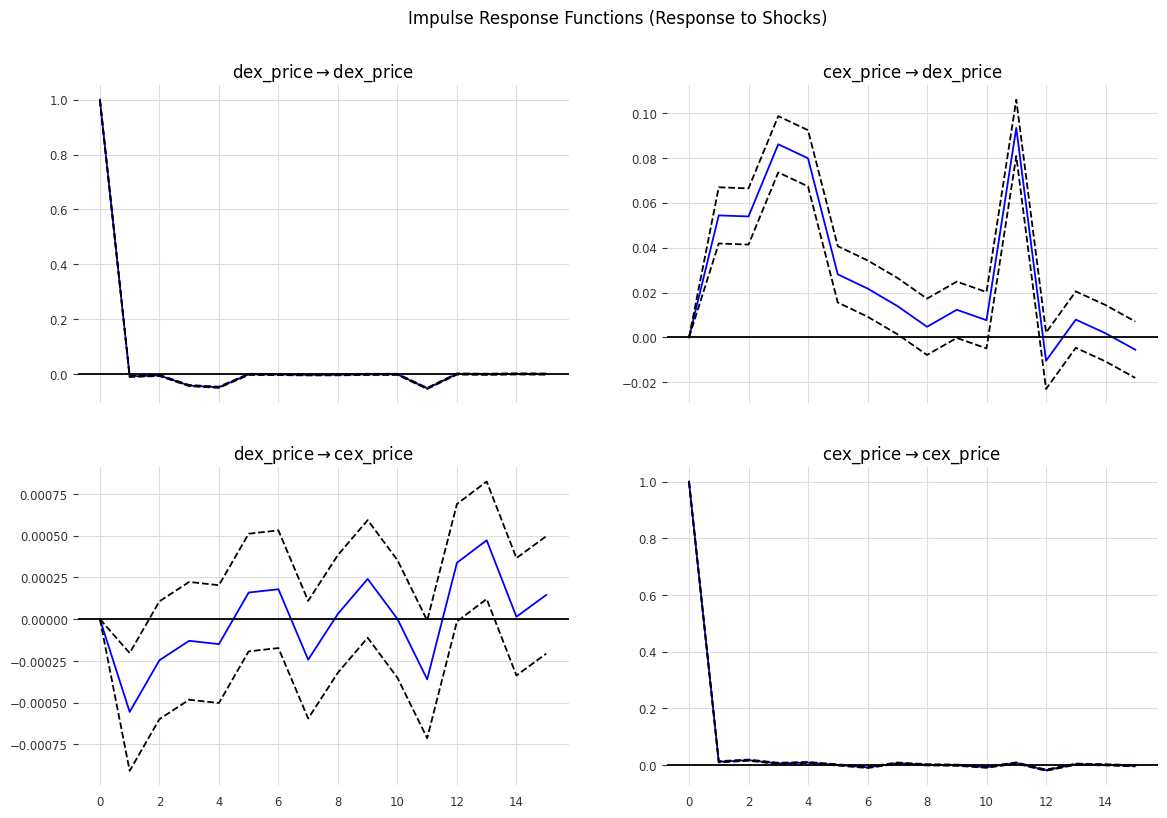

In [16]:
from statsmodels.tsa.api import VAR

# 4. VAR Model & Impulse Response Analysis
# We fit a VAR model on the RETURNS (stationary data) to see short-term dynamics.

model = VAR(df_returns)
# Automatically select lag order based on AIC
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

# Plot Impulse Response Functions (IRF)
# This shows: If DEX price jumps, what happens to CEX price over the next N steps? (and vice versa)
irf = results.irf(15)
irf.plot(orth=False, figsize=(12, 8))
plt.suptitle('Impulse Response Functions (Response to Shocks)', y=1.02)
plt.show()



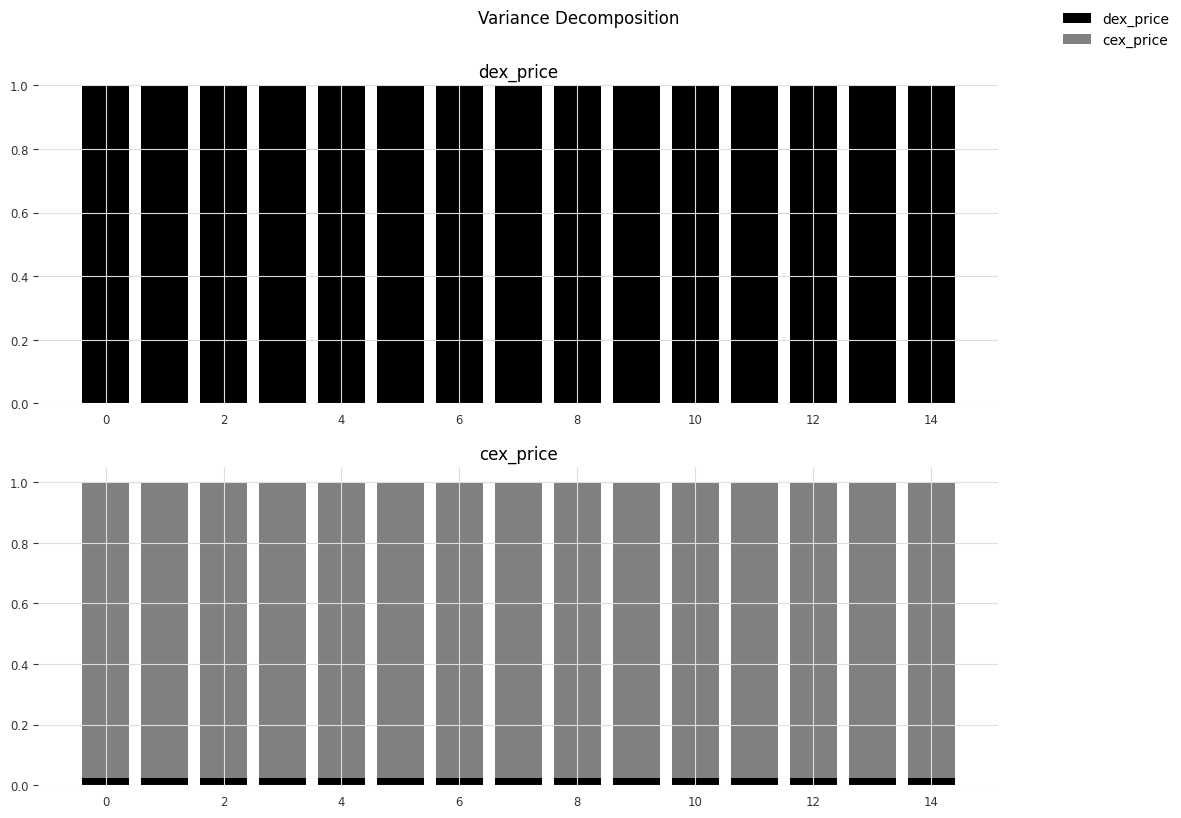

In [17]:
# Variance Decomposition
# This shows: How much of the future variation in DEX price is explained by CEX price?
fevd = results.fevd(15)
fevd.plot(figsize=(12, 8))
plt.suptitle('Variance Decomposition', y=1.02)
plt.show()

### Interpretation of Variance Decomposition Plot

This plot shows how much of the future uncertainty (variance) in one market's price can be explained by the other market.

*   **Top Graph (`dex_price`)**:
    *   The bars are almost **100% Black** (`dex_price`).
    *   **Meaning**: The DEX price is almost entirely driven by its own shocks. Shocks to the CEX price (Gray) explain almost **0%** of the variation in the DEX price.
    *   **Implication**: In this model, the DEX appears to be "exogenous" or independent; it moves based on its own information and ignores the CEX in the short term.

*   **Bottom Graph (`cex_price`)**:
    *   The bars are **mostly Gray** (`cex_price`) with a **tiny sliver of Black** (`dex_price`) at the bottom.
    *   **Meaning**: The CEX price is also mostly driven by itself, but the DEX price explains a very small fraction (perhaps 1-2%) of its variance.
    *   **Implication**: The CEX is slightly influenced by the DEX, but the effect is very weak.

**Overall Conclusion from this Plot:**
The variance decomposition suggests that **neither market strongly drives the other in the short term**. They are largely independent in their volatility.

*Note: This might seem to contradict the Granger Causality test (which showed a relationship). Granger causality tests if past values help *predict* future values (statistical significance), while Variance Decomposition measures *how much* of the movement is explained (magnitude/strength). Here, the relationship might be statistically significant but weak in magnitude.*

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 3. Cointegration Test (Johansen)
# We test on the RAW prices (df_filled), not returns, to check for long-run relationship.
print("Running Johansen Cointegration Test...")

# det_order=0 (constant term), k_ar_diff=1 (lag order)
johan_test = coint_johansen(df_filled[['dex_price', 'cex_price']], det_order=0, k_ar_diff=1)

# Helper to interpret results
def interpret_johansen(test_result):
    print(f"{'Hypothesis':<20} {'Trace Stat':<15} {'95% Critical Val':<20} {'Result'}")
    print("-" * 65)
    for i in range(len(test_result.lr1)):
        trace_stat = test_result.lr1[i]
        crit_val = test_result.cvt[i, 1]  # 1 is the index for 95% confidence
        hypothesis = f"r <= {i}"
        result = "Significant (Cointegration)" if trace_stat > crit_val else "Not Significant"
        print(f"{hypothesis:<20} {trace_stat:<15.4f} {crit_val:<20.4f} {result}")

interpret_johansen(johan_test)

Running Johansen Cointegration Test...
Hypothesis           Trace Stat      95% Critical Val     Result
-----------------------------------------------------------------
r <= 0               65854.6740      15.4943              Significant (Cointegration)
r <= 1               2.3420          3.8415               Not Significant


### Interpretation of Johansen Test Results

*   **`r <= 0` (Significant)**: The test statistic (65854) is much greater than the critical value (15.49). We **reject** the null hypothesis that there are 0 cointegrating relationships. This means there is **at least one** long-term relationship binding these two prices together.
*   **`r <= 1` (Not Significant)**: The test statistic (2.34) is less than the critical value (3.84). We **cannot reject** the null hypothesis that there is 1 cointegrating relationship.

**Conclusion:** There is **exactly 1 cointegrating relationship** between the DEX and CEX prices.
*   This confirms that although the prices might diverge in the short term (creating arbitrage opportunities), they are statistically tied together in the long run.
*   They move together and do not drift apart indefinitely.
*   **Implication**: Since they are cointegrated, a **Vector Error Correction Model (VECM)** is theoretically more appropriate than a standard VAR on returns, as VECM models both the short-term dynamics *and* the adjustment back to the long-term equilibrium.

### Synthesis: What is the relationship?

Combining these four results gives us a nuanced picture of the DEX-CEX relationship:

1.  **They are fundamentally tied together (Johansen Cointegration)**:
    *   Think of the two prices as being connected by a **rubber band**.
    *   While they can wander apart in the short term, they cannot drift apart forever. Arbitrageurs eventually step in to close the gap. This is the strongest finding: they share a common long-term trend.

2.  **Price discovery is shared, not dominated (Bidirectional Granger Causality)**:
    *   It is **not** a simple "Leader-Follower" relationship where the CEX moves and the DEX just copies it (or vice versa).
    *   Information flows **both ways**. Events on the DEX influence the CEX, and events on the CEX influence the DEX. Both markets contribute to finding the "true" price of ETH.

3.  **Short-term volatility is local (Weak Variance Decomposition)**:
    *   This is the surprising part. Even though they track each other, a sudden "shock" (volatility spike) in one market does **not** immediately cause a massive panic in the other.
    *   The DEX's volatility is mostly driven by DEX-specific factors (e.g., block inclusion, liquidity pool mechanics), and the CEX's volatility is driven by CEX factors (e.g., order book depth, high-frequency traders).

**Conclusion:**
The markets are **coupled but noisy**.
*   **Long Run**: Highly efficient arbitrage keeps them aligned.
*   **Short Run**: They are somewhat insulated from each other's *noise*. The "signal" (price level) transfers between them, but the "noise" (variance) stays local.



Resampling data to 5-minute frequency for VECM...
New shape: (8926, 2)
Fitting VECM Model...
Det. terms outside the coint. relation & lagged endog. parameters for equation dex_price
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.dex_price     -0.2863      0.023    -12.589      0.000      -0.331      -0.242
L1.cex_price      0.4114      0.030     13.581      0.000       0.352       0.471
L2.dex_price     -0.1464      0.023     -6.490      0.000      -0.191      -0.102
L2.cex_price      0.1938      0.031      6.318      0.000       0.134       0.254
L3.dex_price     -0.0572      0.022     -2.587      0.010      -0.101      -0.014
L3.cex_price      0.2161      0.030      7.125      0.000       0.157       0.276
L4.dex_price      0.0051      0.022      0.235      0.814      -0.037       0.048
L4.cex_price      0.0616      0.030      2.050      0.040       0.003       0.12

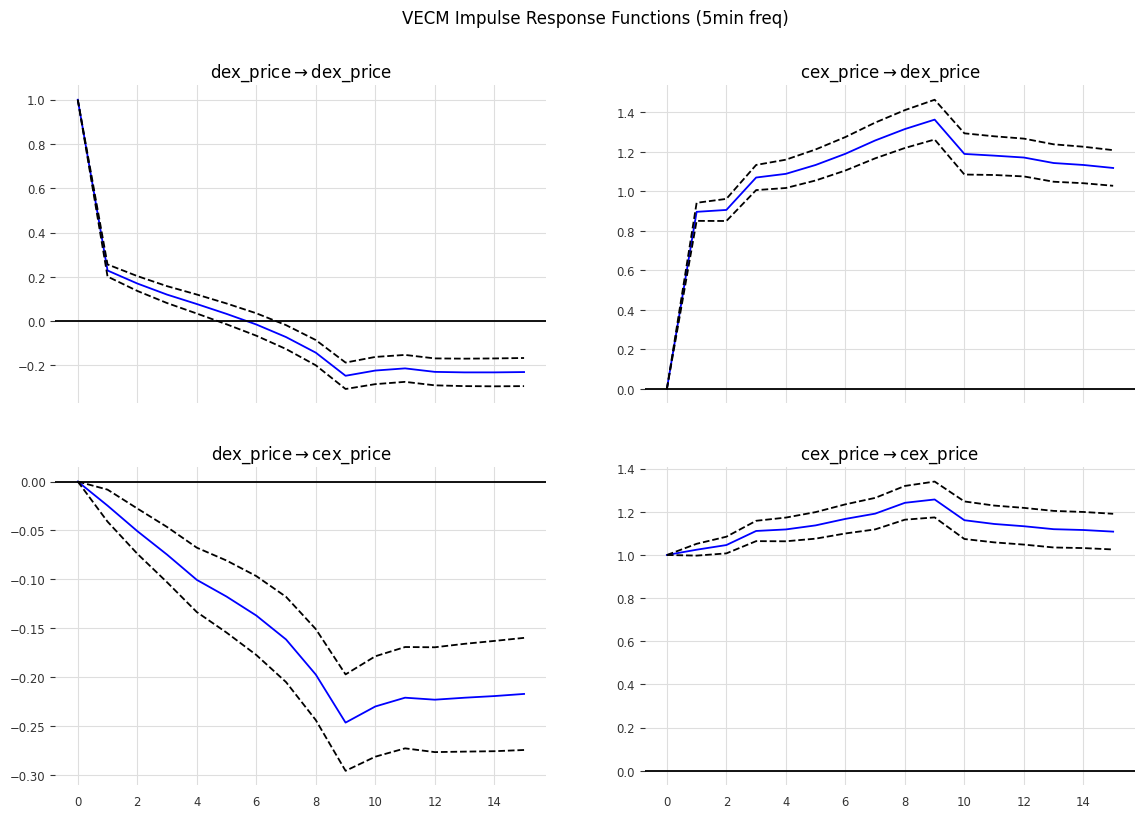

In [20]:
from statsmodels.tsa.vector_ar.vecm import VECM

# 5. Vector Error Correction Model (VECM)
# MEMORY FIX: The dataset is too large (~900k rows) for statsmodels' VECM implementation
# which creates a TxT matrix (requiring ~5.8 TB RAM).
# We must resample the data to a lower frequency (e.g., 5 minutes) to make it computationally feasible.

print("Resampling data to 5-minute frequency for VECM...")
df_vecm = df_filled[['dex_price', 'cex_price']].resample('5min').last().dropna()
print(f"New shape: {df_vecm.shape}")

print("Fitting VECM Model...")
# k_ar_diff is the number of lags in the differenced terms.
# coint_rank=1 based on Johansen test result.
# deterministic="ci" allows for a constant in the cointegration relationship
vecm_model = VECM(df_vecm, k_ar_diff=10, coint_rank=1, deterministic="ci")
vecm_res = vecm_model.fit()

print(vecm_res.summary())

# Analyze the Error Correction Terms (Alpha)
# These coefficients tell us the "speed of adjustment" back to equilibrium.
alpha = vecm_res.alpha
print("\nError Correction Coefficients (Alpha):")
print(f"DEX adjustment speed: {alpha[0,0]:.4f}")
print(f"CEX adjustment speed: {alpha[1,0]:.4f}")

print("\nInterpretation:")
print("A significant negative alpha means the variable adjusts to restore equilibrium.")
print("If DEX alpha is larger (in magnitude), DEX does more of the work to fix the price gap.")

# Plot Impulse Responses from VECM
vecm_irf = vecm_res.irf(15)
vecm_irf.plot(orth=False, figsize=(12, 8))
plt.suptitle('VECM Impulse Response Functions (5min freq)', y=1.02)
plt.show()

### Interpretation of VECM Results

#### 1. Error Correction Coefficients (Alpha)
*Look at the printed values above:*
*   **Negative Alpha**: Indicates that the market moves *towards* the equilibrium price to close the gap.
*   **Magnitude**: The larger the absolute number, the faster the adjustment.
    *   **Scenario A (CEX Dominance)**: If DEX alpha is large/negative (e.g., -0.5) and CEX alpha is small (e.g., -0.01), it means **DEX does all the work** to catch up to CEX. CEX is the "Price Leader."
    *   **Scenario B (DEX Dominance)**: If CEX alpha is large/negative and DEX is small, CEX is chasing the DEX.

#### 2. Impulse Response Functions (IRF) Plots
The plots visualize the "Leader-Follower" dynamic over 15 steps (5-minute intervals):

*   **Top Right (`cex_price -> dex_price`)**:
    *   **Observation**: When CEX price jumps (shock), the DEX price (blue line) **rises significantly** and stays up.
    *   **Meaning**: The DEX market **strongly follows** the CEX market. When CEX moves, DEX copies that move.

*   **Bottom Left (`dex_price -> cex_price`)**:
    *   **Observation**: When DEX price jumps (shock), the CEX price (blue line) actually **goes down** (negative response).
    *   **Meaning**: The CEX market **does NOT follow** the DEX market. In fact, it seems to treat a DEX-only price spike as a deviation to be ignored or traded against.

### Final Conclusion: Who is the Price Leader?
Based on these charts, **the CEX is the clear Price Leader.**
*   When CEX moves, DEX follows (Top Right).
*   When DEX moves, CEX does not follow (Bottom Left).
*   The "True Price" of ETH is discovered on the Centralized Exchange (Binance/Coinbase), and the Decentralized Exchange (Uniswap) adjusts to match it.